# Проект: вариант 1

**`Задачи:`**

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре. 

# ---------------------------------------------------------------------------------------------------------------

Для начала сразу импортируем нужные нам библиотеки для выполнения всех задач.

In [1]:
# Импорт библиотек
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode
from scipy.stats import chi2_contingency
from scipy import stats
import scipy.stats as ss

## Задание 1

**Retention** – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

Загрузим данные и убедимся, что всё считалось правильно

In [2]:
# Загрузка нужных ДатаФреймов
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

- **`reg_data`** - данные о времени регистрации

In [10]:
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


**reg_ts** - дата регистрации 
    
**uid** - идентификатор пользователя 

- **`auth_data`** - данные о времени захода пользователей в игру

In [9]:
auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


**auth_ts** - дата захода пользователя в игру
    
**uid** - идентификатор пользователя 

In [5]:
# Проверка количества строк и столбов 
print(reg_data.shape)
print(auth_data.shape)

(1000000, 2)
(9601013, 2)


In [8]:
# Проверка типов данных 
print(reg_data.dtypes)          
print(auth_data.dtypes)

reg_ts    datetime64[ns]
uid                int64
dtype: object
auth_ts    datetime64[ns]
uid                 int64
dtype: object


Как мы можем заметить, столбцы 'reg_ts' и 'auth_ts' представляют собой Unix-штампы и имеют тип данных int. Переведем их в тип данных datetime, представляющий дату с точностью до дня.

In [7]:
# Преобразование столбцов в тип данных 'datetime'
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.floor('D')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.floor('D')

In [11]:
# Проверка отсутствующих значений
print(reg_data.isnull().sum())
print(auth_data.isnull().sum())

reg_ts    0
uid       0
dtype: int64
auth_ts    0
uid        0
dtype: int64


In [12]:
# Проверка дубликатов
print(reg_data.duplicated().sum())
print(auth_data.duplicated().sum())

0
0


Давайте посмотрим на количество уникальных идентификаторов в столбцах 'reg_ts' и 'auth_ts'.

In [13]:
# Проверка уникальных значений 
print(reg_data['uid'].nunique())
print(auth_data['uid'].nunique())

1000000
1000000


Количество уникальных значений одинаковое, значит, данные, с большой вероятностью, загрузились правильно.

Напишем функцию, которая будет считать **retention** игроков.

In [15]:
def calculate_retention(start_date, end_date, horizon_days=None):
    """
    Рассчитывает retention (коэффициент удержания пользователей) на основе указанных начальной и конечной даты, и 
    при необходимости ограничивает количество дней горизонта.

    Параметры:
    - start_date (datetime64[ns]): Начальная дата для анализа.    
    - end_date (datetime64[ns]): Конечная дата для анализа.
    - horizon_days (int): Количество дней для ограничения расчета удержания (по умолчанию None).

    Возвращает:
    - ur_style: Стилизованная таблица с коэффициентами удержания.
    
    """     

    # Объединение таблиц по столбцу 'uid' 
    merged_df = pd.merge(reg_data, auth_data, on='uid', how='left')

    # Расчет разницы между действием и датой регистрацией 
    merged_df['period'] = (merged_df['auth_ts'] - merged_df['reg_ts']).dt.days

    # Считаем унакальные значения когорты  
    cohorts = merged_df.groupby(['reg_ts', 'period'])['uid'].apply(pd.Series.nunique).reset_index()

    # Данные о количестве уникальных пользователей
    unique_users = cohorts.query("period == 0")[['reg_ts', 'uid']]

    # Объединение таблиц по столбцу 'reg_ts' 
    retention = pd.merge(cohorts, unique_users, on='reg_ts')

    # # Вычисление коэффициента удержания пользователей
    retention['retention_rate'] = retention['uid_x'] / retention['uid_y']

    # Меняем название столбца с датами регистрации (reg_ts) на "cohort" так как это будет являться нашей когортой   
    retention = retention.rename(columns={'reg_ts': 'cohort'})
    
    retention_pivot = retention.pivot(index='cohort', columns='period', values='retention_rate')

    # Фильтрация данных по указанным датам
    filtered_retention = retention_pivot.loc[start_date:end_date]
  
    # Удаление лишних нулевых столбцов справа
    filtered_retention = filtered_retention.loc[:, (filtered_retention != 0).any(axis=0)]

    # Ограничение горизонта расчета retention
    if horizon_days:
        filtered_retention = filtered_retention.iloc[:, :horizon_days+1]
        
    # Определение времени года по месяцу
    def get_season(month):
        if month in [12, 1, 2]:  # Декабрь, Январь, Февраль - Зима
            return 'Blues'
        elif month in [3, 4, 5]:  # Март, Апрель, Май - Весна
            return 'BuPu'
        elif month in [6, 7, 8]:  # Июнь, Июль, Август - Лето
            return 'Greens'
        else:  # Сентябрь, Октябрь, Ноябрь - Осень
            return 'Oranges'

    # Определение цветовой схемы в зависимости от времени года
    season_color = get_season(start_date.month)
 
   
    ur_style = (filtered_retention
                .style
                .set_caption('Retention Table')
                .background_gradient(cmap=season_color)
                .highlight_null('white')
                .format("{:.2%}", na_rep=""))

    return ur_style

In [17]:
# Проверка докстрина
print(calculate_retention.__doc__)


    Рассчитывает retention (коэффициент удержания пользователей) на основе указанных начальной и конечной даты, и 
    при необходимости ограничивает количество дней горизонта.

    Параметры:
    - start_date (datetime64[ns]): Начальная дата для анализа.    
    - end_date (datetime64[ns]): Конечная дата для анализа.
    - horizon_days (int): Количество дней для ограничения расчета удержания (по умолчанию None).

    Возвращает:
    - ur_style: Стилизованная таблица с коэффициентами удержания.
    
    


Так как осной ДатаФрейм достаточно большого размера и функцию можно тестировать на разных частях данных, давайте посмотрим динамику пользователей в разные моменты времени.

Создадим новые таблицы с новым столбцом 'year', чтобы найти год, когда пользователи были максимально активны.

1) Сначала проведем аналитику с таблицей regdata.

2) Потом проделаем точно такие же действия с таблицей authdata.

In [18]:
# Добавляем столбец с годами
reg_data['year'] = reg_data['reg_ts'].dt.year

# Создадим таблицу с уникальными пользователями по годам
data = reg_data.groupby('year', as_index=False).agg({'uid': 'nunique'})

# Добавление нового столбца 'uid_diff' для вычисления разницы с предыдущей строкой в столбце 'uid'
data['uid_diff'] = data['uid'].diff()

In [19]:
data.sort_values('uid_diff', ascending=False).head()

,year,uid,uid_diff
21,2019,291102,131373.0
20,2018,159729,72084.0
22,2020,354963,63861.0
19,2017,87645,39458.0
18,2016,48187,21843.0


In [20]:
# Добавляем столбец с годами
auth_data['year'] = auth_data['auth_ts'].dt.year

# Создадим таблицу с уникальными пользователями по годам
data_2 = auth_data.groupby('year', as_index=False).agg({'uid': 'nunique'})

# Добавление нового столбца 'uid_diff' для вычисления разницы с предыдущей строкой в столбце 'uid'
data_2['uid_diff'] = data_2['uid'].diff()

In [21]:
data_2.sort_values('uid_diff', ascending=False).head()

,year,uid,uid_diff
21,2019,311202,140425.0
22,2020,391646,80444.0
20,2018,170777,77110.0
19,2017,93667,42206.0
18,2016,51461,23333.0


Самый активный рост по регистрациям и входам в игру наблюдается с 2018 по 2019 год. Поэтому мы будем тестировать код именно в этот промежуток времени.

Посмотрим, как общая картина выглядит на графиках.

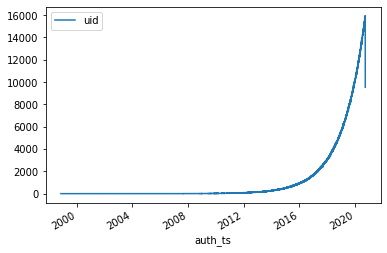

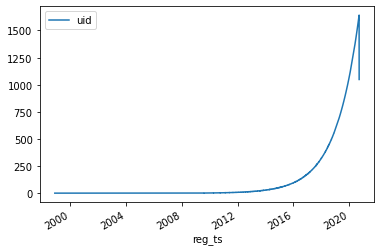

In [22]:
# Добавляем графики
auth_data.groupby('auth_ts').agg({'uid': 'nunique'}).plot()
reg_data.groupby('reg_ts').agg({'uid': 'nunique'}).plot()

Будем проводить два теста по удержанию (retention) за два месяца в рамках полугодия - в январе и июле.

**`ЯНВАРЬ:`**

In [54]:
# Установка размера графика и стиля
sns.set(rc={'figure.figsize': (10, 14)}, style="whitegrid")

# Пример использования функции для анализа retention с указанием нужных дат, горизонта и стиля
start_date = pd.Timestamp('2018-01-01')
end_date = pd.Timestamp('2018-01-31')
horizon_days = 10
retention_style = calculate_retention(start_date, end_date, horizon_days)

# Вывод стилизованной таблицы
retention_style

period,0,1,2,3,4,5,6,7,8,9,10
cohort,,,,,,,,,,,
2018-01-01 00:00:00,100.00%,1.56%,3.44%,2.50%,6.25%,8.75%,5.94%,3.75%,3.44%,5.62%,5.94%
2018-01-02 00:00:00,100.00%,1.25%,5.62%,4.38%,5.94%,5.31%,6.88%,3.75%,5.31%,3.12%,5.62%
2018-01-03 00:00:00,100.00%,1.56%,3.44%,8.12%,6.56%,7.19%,6.56%,4.38%,4.06%,7.19%,5.62%
2018-01-04 00:00:00,100.00%,1.55%,5.90%,4.35%,6.83%,4.66%,7.45%,7.45%,4.97%,7.45%,6.21%
2018-01-05 00:00:00,100.00%,1.56%,5.92%,4.67%,4.98%,4.67%,8.41%,8.10%,4.67%,5.92%,4.67%
2018-01-06 00:00:00,100.00%,1.86%,3.72%,2.79%,5.26%,6.19%,6.50%,5.26%,4.33%,4.33%,5.26%
2018-01-07 00:00:00,100.00%,3.73%,5.28%,4.66%,5.28%,5.59%,6.52%,6.21%,5.59%,7.76%,4.66%
2018-01-08 00:00:00,100.00%,3.09%,5.86%,5.25%,5.56%,7.10%,9.26%,6.48%,5.56%,4.63%,7.41%
2018-01-09 00:00:00,100.00%,4.01%,6.17%,3.09%,5.56%,4.94%,5.56%,7.41%,4.63%,5.86%,5.86%


**`ИЮЛЬ:`**

In [55]:
# Установка размера графика и стиля
sns.set(rc={'figure.figsize': (10, 14)}, style="whitegrid")

# Пример использования функции для анализа retention с указанием нужных дат, горизонта и стиля
start_date = pd.Timestamp('2018-07-01')
end_date = pd.Timestamp('2018-07-31')
horizon_days = 10
retention_style = calculate_retention(start_date, end_date, horizon_days)

# Вывод стилизованной таблицы
retention_style

period,0,1,2,3,4,5,6,7,8,9,10
cohort,,,,,,,,,,,
2018-07-01 00:00:00,100.00%,3.71%,2.55%,5.57%,7.42%,6.96%,7.42%,5.57%,7.42%,3.02%,6.96%
2018-07-02 00:00:00,100.00%,1.86%,2.32%,6.26%,6.50%,5.10%,5.10%,4.87%,4.87%,5.34%,7.66%
2018-07-03 00:00:00,100.00%,1.62%,3.70%,5.09%,5.32%,6.71%,5.79%,5.32%,4.63%,5.79%,5.32%
2018-07-04 00:00:00,100.00%,2.08%,3.47%,3.70%,6.02%,3.94%,6.48%,4.86%,3.24%,4.86%,5.79%
2018-07-05 00:00:00,100.00%,1.61%,3.69%,4.61%,4.38%,5.30%,7.83%,5.07%,4.38%,5.99%,4.84%
2018-07-06 00:00:00,100.00%,2.08%,2.54%,6.47%,5.08%,4.16%,7.85%,5.77%,5.31%,6.00%,6.24%
2018-07-07 00:00:00,100.00%,3.22%,2.76%,5.29%,5.29%,5.06%,6.44%,6.44%,3.68%,5.06%,4.60%
2018-07-08 00:00:00,100.00%,1.61%,4.82%,4.59%,5.05%,5.28%,6.42%,4.59%,4.82%,5.05%,5.28%
2018-07-09 00:00:00,100.00%,2.75%,3.67%,2.98%,7.11%,3.90%,7.11%,5.28%,5.50%,3.67%,5.73%


# ---------------------------------------------------------------------------------------------------------------

##  Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Для начала загрузим данные и проведем первичный анализ.

In [2]:
# Скачиваем и загружаем 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-mitruschenkov/Проект_1_Задание_2.csv', 'wb') as f:   
    f.write(download_response.content)
    
df = pd.read_csv('~/Проект_1_Задание_2.csv', sep=';')

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


**user_id** - ид пользователя

**revenue** - выручка 

**testgroup** - группы (a-контрольная, b-тестовая)

In [4]:
# Проверка количества строк и столбов 
df.shape

(404770, 3)

In [5]:
# Проверка типов данных 
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [6]:
# Проверка отсутствующих значений
df.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [7]:
# Проверка дубликатов
df.duplicated().sum()

0

Разделим ДатаФрейм на контрольную и тестовую группу, чтобы провести сравнение.

In [8]:
# Контрольная группа
control_group = df.query('testgroup == "a"') 


control_group.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [9]:
# Тестовая группа 
test_group = df.query('testgroup == "b"') 

test_group.head()

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b


Посмотрим на разницу между платящими и не платящими пользователями в обеих группах.

In [10]:
# Разница в контрольной группе
paying_control_group = control_group['revenue'].apply(lambda x: 'Paying' if x > 0 else 'Non-paying').value_counts()

paying_control_group

Non-paying    200175
Paying          1928
Name: revenue, dtype: int64

In [11]:
# Разница в тестовой группе
paying_test_group = test_group['revenue'].apply(lambda x: 'Paying' if x > 0 else 'Non-paying').value_counts()

paying_test_group

Non-paying    200862
Paying          1805
Name: revenue, dtype: int64

Для наглядности построим два графика.

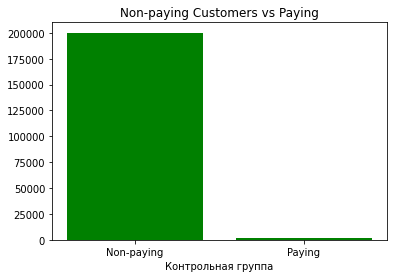

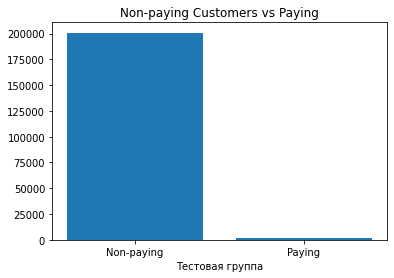

In [12]:
# Построение графика .bar
plt.bar(paying_control_group.index, paying_control_group.values, color='g')
plt.xlabel('Контрольная группа')
plt.title('Non-paying Customers vs Paying')
plt.show()

# Построение графика .bar
plt.bar(paying_test_group.index, paying_test_group.values)
plt.xlabel('Тестовая группа')
plt.title('Non-paying Customers vs Paying')
plt.show()

Есть значительный дисбаланс в пользу неплатящих пользователей по сравнению с платящими, что приводит к ненормальному распределению.

Расчет **ARPU** для каждой группы

#### | ARPU=Конверсия⋅ARPPU |

Для подсчета **ARPU** нам понадобятся показатели **Конверсии** и **ARPPU**

Расчет **Конверсии** для каждой группы

#### | Конверсия=Число клиентов/Число пользователей |

In [13]:
# Конверсия контрольной группы:

# Число клиентов 
number_clients_control = control_group \
    .query("revenue!='0'")['user_id'].nunique()

# Число пользователей
number_users_control = control_group['user_id'].nunique()

# Конверсия 
conversion_control = number_clients_control / number_users_control

# Для удобства выведем значение в процентах
conversion_control_percent = round((conversion_control) * 100, 2)

# Конверсия тестовой группы:

# Число клиентов 
number_clients_test = test_group \
    .query("revenue!='0'")['user_id'].nunique()

# Число пользователей
number_users_test = test_group['user_id'].nunique()

# Конверсия 
conversion_test = number_clients_test / number_users_test 

# Для удобства выведем значение в процентах
conversion_test_percent = round((conversion_test) * 100, 2)

print("1) Число клиентов:")
print("В контрольной группе:", number_clients_control)
print("В тестовой группе:", number_clients_test)  
print("2) Число пользователей:")
print("В контрольной группе:", number_users_control)
print("В тестовой группе:", number_users_test)  
print("3) Конверсия:")  
print("В контрольной группе:", conversion_control_percent)
print("В тестовой группе:", conversion_test_percent) 

1) Число клиентов:
В контрольной группе: 1928
В тестовой группе: 1805
2) Число пользователей:
В контрольной группе: 202103
В тестовой группе: 202667
3) Конверсия:
В контрольной группе: 0.95
В тестовой группе: 0.89


Расчет **ARPPU** для каждой группы

#### | ARPPU= Доход/Число клиентов |

In [14]:
# ARPPU контрольной группы:

# Доход
revenue_control = control_group['revenue'].sum()

# Число клиентов
number_clients_control = control_group \
.query("revenue!='0'")['user_id'].nunique()

# ARPPU
ARPPU_control = round(revenue_control / number_clients_control, 2)

# ARPPU тестовой группы:

# Доход
revenue_test = test_group['revenue'].sum()

# Число клиентов
number_clients_test = test_group \
.query("revenue!='0'")['user_id'].nunique()

# ARPPU
ARPPU_test = round(revenue_test / number_clients_test, 2)

print("4) Доход:")
print("В контрольной группе:", revenue_control)
print("В тестовой группе:", revenue_test)
print("5) ARPPU:")  
print("В контрольной группе:", ARPPU_control)
print("В в тестовой группе:", ARPPU_test)

4) Доход:
В контрольной группе: 5136189
В тестовой группе: 5421603
5) ARPPU:
В контрольной группе: 2664.0
В в тестовой группе: 3003.66


Расчет **ARPU** для каждой группы

In [15]:
# ARPU контрольной группе
ARPU_control = round(conversion_control * ARPPU_control, 2)

# ARPU тестовой группе
ARPU_test = round(conversion_test * ARPPU_test, 2)

print("6) ARPU:")  
print("В контрольной группе:", ARPU_control)
print("В тестовой группе:", ARPU_test)

6) ARPU:
В контрольной группе: 25.41
В тестовой группе: 26.75


Добавим таблицу, чтобы удобно посмотреть на наши итоговые вычисления.

In [16]:
# Создаем словарь с данными
data = {'groups': ["a", "b"], 'number_clients': [number_clients_control, number_clients_test],
        'number_users': [number_users_control, number_users_test],
        'conversion': [conversion_control_percent, conversion_test_percent], 'revenue': [revenue_control, revenue_test],
        'ARPPU': [ARPPU_control, ARPPU_test], 'ARPU': [ARPU_control, ARPU_test]} 

# Создаем DataFrame, используя словарь с данными и указанным индексом
comparison_table = pd.DataFrame(data, index=['control', 'test'])

In [17]:
comparison_table

,groups,number_clients,number_users,conversion,revenue,ARPPU,ARPU
control,a,1928,202103,0.95,5136189,2664.00,25.41
test,b,1805,202667,0.89,5421603,3003.66,26.75


**groups** - группы (a-контрольная, b-тестовая)

**number_clients** - Число клиентов

**number_users** - Число пользователей

**conversion** - Конверсия

**revenue** - Доход

**ARPPU** - Средний доход на платящего пользователя (то есть клиента).

**ARPU** - Cредний доход с привлечённого пользователя.

Сравним все имеющиеся показатели.

In [18]:
# Число клиентов
diff_number_clients = number_clients_test - number_clients_control

diff_number_clients_percent = round((((number_clients_test / number_clients_control) - 1) * 100), 2)

# Число пользователей
diff_number_users = number_users_test - number_users_control

diff_number_users_percent = round((((number_users_test / number_users_control) - 1) * 100), 2)

# Конверсия
diff_conversion_percent = round((((conversion_test_percent / conversion_control_percent) - 1) * 100), 2)

# Доход
diff_revenue = revenue_test - revenue_control

diff_revenue_percent = round((((revenue_test / revenue_control) - 1) * 100), 2)

# Средний доход на платящего пользователя (то есть клиента)
diff_ARPPU = round((ARPPU_test - ARPPU_control), 2)

diff_ARPPU_percent = round((((ARPPU_test / ARPPU_control) - 1) * 100), 2)

# Cредний доход с привлечённого пользователя
diff_ARPU = round((ARPU_test - ARPU_control), 2)

diff_ARPU_percent = round((((ARPU_test / ARPU_control) - 1) * 100), 2)

print(" 1) Разница числа клиентов:", diff_number_clients)
print("    В процентах:", diff_number_clients_percent)
print(" 2) Разница числа пользователей:", diff_number_users)
print("    В процентах:", diff_number_users_percent)
print(" 3) Разница конверсии в процентах:", diff_conversion_percent)
print(" 4) Разница суммы доходов:", diff_revenue)
print("    В процентах:", diff_revenue_percent)
print(" 5) (ARPPU)Разница среднего дохода на платящего пользователя (то есть клиента):", diff_ARPPU)
print("    В процентах:", diff_ARPPU_percent)
print(" 6) (ARPU) Разница среднего дохода с привлечённого пользователя:", diff_ARPU)
print("    В процентах:", diff_ARPU_percent)

 1) Разница числа клиентов: -123
    В процентах: -6.38
 2) Разница числа пользователей: 564
    В процентах: 0.28
 3) Разница конверсии в процентах: -6.32
 4) Разница суммы доходов: 285414
    В процентах: 5.56
 5) (ARPPU)Разница среднего дохода на платящего пользователя (то есть клиента): 339.66
    В процентах: 12.75
 6) (ARPU) Разница среднего дохода с привлечённого пользователя: 1.34
    В процентах: 5.27


### Сравнение двух групп (control  и test):

Исходя из полученных данных произведем сравнение двух групп. Основной акцент будем делать на нормированные метрики, такие как **ARPU**, **ARPPU** и **конверсия**, так как они более информативны при сравнении различных групп.

На данный момент мы видим, что:

Увеличение **ARPU** (средний доход с пользователя) на 1.34 (+5.27%) произошло в тестовой группе (по сравнению с контрольной).

Увеличение **ARPPU** (средний доход на платящего пользователя, то есть клиента) на 339.66 (+12.75%) произошло в тестовой группе (по сравнению с контрольной).

**Конверсия** уменьшилась на (-6.32%) в тестовой группе (по сравнению с контрольной).

Но все эти показатели должны быть проверены статистикой.

Для подтверждения статистической значимости по метрикам **ARPU** и **ARPPU** будем использовать **t-тест**. Так как на практике t-тест более точен при сравнении двух средних значений даже в случае ненормального распределения данных, особенно при больших выборках, как в нашем случае. В то время как тест Манна-Уитни, предназначенный для ненормально распределенных данных, обычно менее чувствителен и имеет меньшую точность по сравнению с t-тестом.

Дисперсионный анализ также может быть применен для сравнения двух групп, однако обычно он используется для анализа различий между тремя и более группами. Чем больше групп участвует в анализе, тем более информативными и точными будут результаты.

Поэтому я пришел к решению использовать **t-тест**, так как он является наилучшим вариантом для данной задачи.

**`1`** Проверка статистической значимости **ARPU** (среднего дохода с пользователя). 

Добавим нулевую и альтернативную гипотезу:

**H₀**(нулевая гипотеза): увеличение показателя ARPU не значимо статистически (между группами, по этой метрике, взаимосвязи нет).

**H₁**(альтернативная гипотеза): увеличение показателя ARPU статистически значимо (между группами, по этой метрике, взамосвязь есть). 

In [19]:
# Выполнение t-теста
t_stat_arpu, p_value_arpu = ss.ttest_ind(control_group['revenue'],
                                         test_group['revenue'], equal_var=False)

In [20]:
# Вывод результатов
if round(p_value_arpu, 2) < 0.05: # уровень значимости 0.05
    print("Увеличение показателя ARPU статистически значимо (между группами, по этой метрике, взамосвязь есть), так как p_value < 0.05."
    "p_value =", round(p_value_arpu, 2)) 
else:
    print("Увеличение показателя ARPU не значимо статистически (между группами, по этой метрике, взаимосвязи нет), так как p_value > 0.05." 
    "p_value =", round(p_value_arpu, 2)) 

Увеличение показателя ARPU не значимо статистически (между группами, по этой метрике, взаимосвязи нет), так как p_value > 0.05.p_value = 0.53


**`2`** Проверка статистической значимости **ARPPU** (средний доход на платящего пользователя, то есть клиента). Данная проверка будет выполнена с помощью t-теста.

Добавим нулевую и альтернативную гипотезу:

**H₀**(нулевая гипотеза): увеличение показателя ARPPU не значимо статистически (между группами, по этой метрике, взаимосвязи нет).

**H₁**(альтернативная гипотеза): увеличение показателя ARPPU статистически значимо (между группами, по этой метрике, взамосвязь есть).

In [21]:
# Выполнение t-теста
t_stat_arppu, p_value_arppu = ss.ttest_ind(control_group[control_group['revenue'] > 0].revenue,
                               test_group[test_group['revenue'] > 0].revenue, equal_var=False)

In [22]:
# Вывод результатов
if round(p_value_arppu, 2) < 0.05: # уровень значимости 0.05
    print("Увеличение показателя ARPPU статистически значимо (между группами, по этой метрике, взамосвязь есть), так как p_value < 0.05."
    "p_value =", round(p_value_arppu, 2)) 
else:
    print("Увеличение показателя ARPPU не значимо статистически (между группами, по этой метрике, взаимосвязи нет), так как p_value > 0.05." 
    "p_value =", round(p_value_arppu, 2)) 

Увеличение показателя ARPPU не значимо статистически (между группами, по этой метрике, взаимосвязи нет), так как p_value > 0.05.p_value = 0.1


Для сравнения **конверсии** будем использовать **Хи-квадрат**. Такой тест поможет нам определить, являются ли эти различия статистически значимыми. Этот тест применяется при сравнении наблюдаемых частот с ожидаемыми частотами. Как в нашем случаи  между контрольной и тестовой группой.

**`3`** Проверка статистической значимости **конверсии**. Данная проверка будет выполнена с помощью теста Хи-квадрат.

Для начала надо подготовить данные о количестве платящих и неплатящих пользователей в разных группах.

In [23]:
# создаем таблицу с платящами пользователями по группам
paying_users = df[df['revenue'] > 0] \
    .groupby('testgroup', as_index=False) \
    .agg({'user_id': 'nunique'}) \
    .rename(columns={'user_id': 'paying_users'})
    
print(paying_users)

  testgroup  paying_users
0         a          1928
1         b          1805


In [24]:
# создаем таблицу с неплатящами пользователями по группам
non_paying_users = df[df['revenue'] == 0] \
    .groupby('testgroup', as_index=False) \
    .agg({'user_id': 'nunique'}) \
    .rename(columns={'user_id': 'non_paying_users'})

print(non_paying_users)

  testgroup  non_paying_users
0         a            200175
1         b            200862


Добавим нулевую и альтернативную гипотезу:

**H₀**(нулевая гипотеза): снижение показателя конверсии не значимо статистически (между группами, по этой метрике, взаимосвязи нет). 

**H₁**(альтернативная гипотеза): снижение показателя конверсии статистически значимо (между группами, по этой метрике, взамосвязь есть). 

Для дальнейшего теста объединим два ДатаФрейма 'clients' и 'users'.  

In [25]:
# объединение таблиц по столбу 'testgroup'
merged_users = pd.merge(paying_users, non_paying_users, on='testgroup')

Удалим из таблицы столбец 'testgroup', так как он может повлиять на результат Хи-квадрат.

In [26]:
# удаление столба 'testgroup'
merged_users = merged_users.drop('testgroup', axis=1)

In [27]:
merged_users

,paying_users,non_paying_users
0,1928,200175
1,1805,200862


In [28]:
# Критерий Хи-квадрат
chi2, p, dof, expected = chi2_contingency(merged_users)

print(round((p),3))

0.036


In [29]:
# Вывод результатов
if round(p, 3) < 0.05: # уровень значимости 0.05
    print("Снижение показателя конверсии статистически значимо (между группами, по этой метрике, взамосвязь есть), так как p_value < 0.05."
    "p_value =", round(p, 3)) 
else:
    print("Снижение показателя конверсии не значимо статистически (между группами, по этой метрике, взаимосвязи нет), так как p_value > 0.05." 
    "p_value =", round(p, 3)) 

Снижение показателя конверсии статистически значимо (между группами, по этой метрике, взамосвязь есть), так как p_value < 0.05.p_value = 0.036


Добавим графики с суммарными показателями. Такими как: число клиентов, число пользователей и доход.

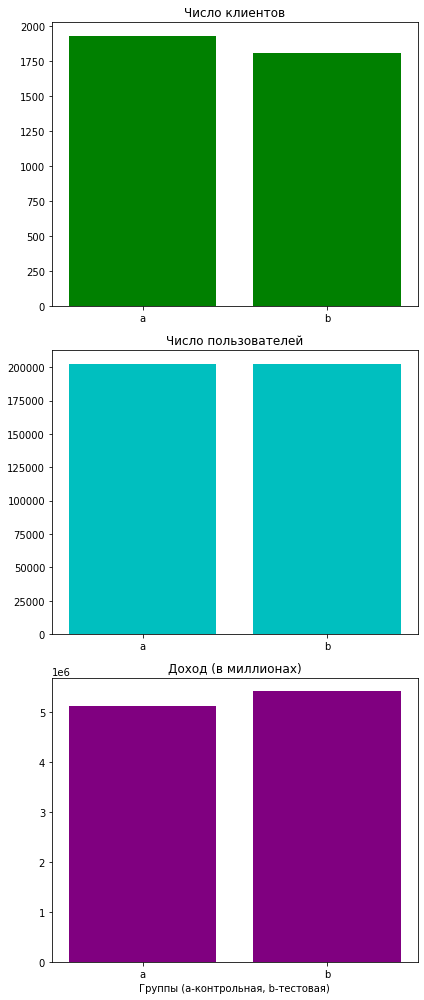

In [30]:
# Добавление графиков
fig, axs = plt.subplots(3, 1, figsize=(6, 14))

axs[0].bar(comparison_table['groups'], comparison_table['number_clients'], color='g')
axs[0].set_title('Число клиентов')

axs[1].bar(comparison_table['groups'], comparison_table['number_users'], color='c')
axs[1].set_title('Число пользователей')

axs[2].bar(comparison_table['groups'], comparison_table['revenue'], color='purple')
axs[2].set_title('Доход (в миллионах)')

plt.xlabel('Группы (a-контрольная, b-тестовая)')
plt.tight_layout()
plt.show()

### Общие выводы:
 

1. Метрики **ARPPU** и **ARPU**:
    - Увеличение ARPPU на 339.66 (+12.75%) в тестовой группе не обладает статистической значимостью, что требует дополнительной проверки для подтверждения роста.
    - Аналогично, увеличение ARPU на 1.34 (+5.27%) также не является статистически значимым изменением.
    

2. Метрика **Конверсия**:
    - Статистически значимое уменьшение разницы в конверсии на 6.32% в тестовой группе по сравнению с контрольной свидетельствует о негативном сигнале. 
    
    
3. **Суммарные показатели**:
     - Суммарные показатели, такие как: число клиентов, число пользователей и доход, могут быть искажены из-за различий в численности выборок, вызванных особенностями дизайна эксперимента и алгоритма сплитования. Поэтому для более информативного анализа рекомендуется нормировать метрики, которые показывают выручку или число покупок (в расчете на одного юзера) - например, средние (ARPU, ARPPU) или конверсия. А суммарные метрики интереснее рассматривать в динамике. Но здесь не тот случай.

###  ИТОГОВЫЙ ВЫВОД:
Подчеркну, что статистически значимые изменения в метриках, особенно важных для бизнеса, имеют большее влияние на принятие решений, чем нестатистически значимые изменения.

1. Статистически значимой разницы в ARPU и ARPPU нет (Возможно при повторном A/B тесте результаты будут другими).
2. Конверсия выше у контрольной группы — это указывает на то, что изменения, внесенные в тестовой группе, не привели к желаемым результатам или даже ухудшили ситуацию.

Итак, исходя из данных A/B теста, можно сделать вывод, что тестовый вариант не привел к улучшению нормированных метрик и даже привел к ухудшению конверсии. С учетом этих результатов, рекомендуется отказаться от внедрения тестового варианта на всех пользователей, поскольку он не оправдал ожиданий и не привел к увеличению ключевых метрик. Оставляем набор акционных предложений из варианта А (контрольная группа).

# ---------------------------------------------------------------------------------------------------------------

## 3 Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### В качестве основных метрик можно взять:

#### - Conversion: 

процент игроков, успешно завершивших все уровни и получивших награду.

#### - Retention Rate:

количество игроков, возвращающихся в игру после первого дня события в течение события.

#### - LTV:

доход от пользователя, привлеченного во время события.

#### - Loyalty:

позволит оценить лояльность игроков к событию.

#### - Дневная аудитория (DAU): 

количество уникальных игроков, посетивших игру в течение суток.

#### - Месячная аудитория (MAU):

количество уникальных игроков, посетивших игру в течение месяца. По отношению средней дневной аудитории к месячной можно понять частоту использования продукта.

#### - Доля новых пользователей:

отношение числа новых игроков за определенный период ко всем игрокам за этот же период.

-------------------------------------------------------------------------------------------------------------------------------


Также можно провести A/B-тест, сравнив месяц события с любым другим событием, чтобы узнать, в какой месяц больше средний онлайн игроков. С помощью критерия хи-квадрат можно определить, имеет ли разница статистическую значимость.


-------------------------------------------------------------------------------------------------------------------------------

Дополнительные метрики отслеживания могут включать:
#### - Уровень участия: 

процент активных игроков, принимавших участие в событии.

#### - Прохождение уровней: 

процент игроков, успешно завершивших все уровни события.

#### - Количество полученных уникальных предметов или бонусов: 

количество уникальных вознаграждений, полученных игроками во время события.

-------------------------------------------------------------------------------------------------------------------------------

При усложнении механики событий, добавлении отката на несколько уровней при неудачной попытке, можно рассмотреть дополнительные метрики:

#### - Частота откатов: 

среднее количество раз, когда игрокам пришлось откатываться на уровни назад.

#### - Затраченное время:

изменение в среднем времени, потраченном на прохождение события из-за откатов.

#### - Отказы от участия:

процент игроков, прекративших участие из-за сложности механики откатов.

Эти метрики помогут оценить, как изменение механики событий повлияло на поведение игроков и их удовлетворенность прохождением уровней.

# -----------------------------------------------------------------------------------------------------------------